In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import os
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

# YKD LAKE Model Benchmarking
This script is used to compare one or multiple LAKE model runs with obsereved water temperatures and concentrations of CO2 and CH4. The data preparation relies on LAKE model output in the second format option (output files ending in '1f2.dat').

In [2]:
datafile_names = {'layers': 'layers  1  1.dat',
                  'water_temp': 'water_temp  1  1f2.dat',
                  'co2_water': 'co2_water  1  1f2.dat',
                  'ch4_water': 'methane_water  1  1f2.dat',
                  'o2_water': 'oxygen_water  1  1f2.dat',
                  'doc_water': 'DOC  1  1f2.dat'}

In [3]:
print('Methane concentration, $\mu g/l$')

Methane concentration, $\mu g/l$


In [4]:
#paths_to_burned_LAKE_output = ['/home/amullen/LAKE/results/YKD-burned_bgc-default/time_series', '/home/amullen/LAKE/results/YKD-burned_bgc-lift/time_series']
#paths_to_burned_LAKE_output = ['/home/amullen/LAKE/results/YKD-burned-8y/time_series', '/home/amullen/LAKE/results/YKD-burned/time_series']
paths_to_burned_LAKE_output = ['/home/amullen/Lake-Model-Data/multi_processing/outputs/LAKE{}/results/YKD{}/time_series'.format(i,i) for i in range(0,10)]
paths_to_burned_LAKE_output = paths_to_burned_LAKE_output[:4]+paths_to_burned_LAKE_output[5:]
#paths_to_unburned_LAKE_output = ['/home/amullen/LAKE/results/YKD-burned_bgc-default/time_series', '/home/amullen/LAKE/results/YKD-burned_bgc-lift/time_series']
#paths_to_unburned_LAKE_output = ['/home/amullen/LAKE/results/YKD-burned-8y/time_series', '/home/amullen/LAKE/results/YKD-burned/time_series']
paths_to_unburned_LAKE_output = ['/home/amullen/Lake-Model-Data/multi_processing/outputs/LAKE{}/results/YKD{}/time_series'.format(i,i) for i in range(0,10)]
paths_to_unburned_LAKE_output = paths_to_unburned_LAKE_output[:4]+paths_to_unburned_LAKE_output[5:]

In [5]:
path_to_unburned_co2_obs = '../data/raw/UB_Pond_CO2_062622-072822.csv'
path_to_burned_co2_obs = '../data/raw/Burned_Pond_CO2_062422-081622.csv'
path_to_ch4_obs = '../data/raw/Pond_Env_For_Elchin.xlsx'

In [6]:
unburned_co2_obs = pd.read_csv(path_to_unburned_co2_obs, parse_dates=['Date'])
min_ub_co2_date = unburned_co2_obs['Date'].min()
max_ub_co2_date = unburned_co2_obs['Date'].max()
burned_co2_obs = pd.read_csv(path_to_burned_co2_obs, parse_dates=['Date'])
min_bu_co2_date = burned_co2_obs['Date'].min()
max_bu_co2_date = burned_co2_obs['Date'].max()

In [7]:
ch4_obs = pd.read_excel(path_to_ch4_obs, parse_dates=['date'])
min_ch4_date = ch4_obs['date'].min()
max_ch4_date = ch4_obs['date'].max()

In [8]:
#get layer thickness df for burned runs
burned_layer_df = []
for out_path in paths_to_burned_LAKE_output:
    print(out_path)
    
    layers=pd.read_csv(os.path.join(out_path, datafile_names['layers']), delimiter=r"\s+", skiprows=19, index_col=None, header=None)
    layers.columns=['year', 'month', 'day', 'hour', 'integration_time', 'water layer thickness, m', 
                           'W mixed layer thickness, m', 'E mixed layer thickness, m', 'S mixed layer thickness, m', 'N mixed layer thickness, m',
                           'W lower layer thickness, m', 'E lower layer thickness, m', 'S lower layer thickness, m', 'N lower layer thickness, m',
                           'ice layer thickness,   m', 'snow layer thickness,  m', 'bottom ice thickness,  m', 'reservoir volume,  m**3', 'volume deficit (accumulated),  m**3']
    layers['datetime'] = pd.to_datetime({'Year': layers['year'], 'Month': layers['month'], 'Day':layers['day']})
    layers['mean_mixed_layer_thickness'] = layers[['W mixed layer thickness, m', 'E mixed layer thickness, m', 'S mixed layer thickness, m', 'N mixed layer thickness, m']].mean(axis=1)
    layers['mean_lower_layer_thickness'] = layers[['W lower layer thickness, m', 'E lower layer thickness, m', 'S lower layer thickness, m', 'N lower layer thickness, m']].mean(axis=1)
    layers = layers.drop(columns = ['W mixed layer thickness, m', 'E mixed layer thickness, m', 'S mixed layer thickness, m', 'N mixed layer thickness, m',
                                    'W lower layer thickness, m', 'E lower layer thickness, m', 'S lower layer thickness, m', 'N lower layer thickness, m'])
    layers['run_name'] = out_path.split('/')[-2]
    print(layers['run_name'])
    burned_layer_df.append(layers)

burned_layer_df = pd.concat(burned_layer_df)

/home/amullen/Lake-Model-Data/multi_processing/outputs/LAKE0/results/YKD0/time_series
0      YKD0
1      YKD0
2      YKD0
3      YKD0
4      YKD0
       ... 
360    YKD0
361    YKD0
362    YKD0
363    YKD0
364    YKD0
Name: run_name, Length: 365, dtype: object
/home/amullen/Lake-Model-Data/multi_processing/outputs/LAKE1/results/YKD1/time_series
0      YKD1
1      YKD1
2      YKD1
3      YKD1
4      YKD1
       ... 
360    YKD1
361    YKD1
362    YKD1
363    YKD1
364    YKD1
Name: run_name, Length: 365, dtype: object
/home/amullen/Lake-Model-Data/multi_processing/outputs/LAKE2/results/YKD2/time_series
0      YKD2
1      YKD2
2      YKD2
3      YKD2
4      YKD2
       ... 
360    YKD2
361    YKD2
362    YKD2
363    YKD2
364    YKD2
Name: run_name, Length: 365, dtype: object
/home/amullen/Lake-Model-Data/multi_processing/outputs/LAKE3/results/YKD3/time_series
0      YKD3
1      YKD3
2      YKD3
3      YKD3
4      YKD3
       ... 
360    YKD3
361    YKD3
362    YKD3
363    YKD3
364    YKD3

In [9]:
#get layer thickness df for unburned runs
unburned_layer_df = []
for out_path in paths_to_unburned_LAKE_output:
    
    print(out_path)
    layers=pd.read_csv(os.path.join(out_path, datafile_names['layers']), delimiter=r"\s+", skiprows=19, index_col=None, header=None)
    layers.columns=['year', 'month', 'day', 'hour', 'integration_time', 'water layer thickness, m', 
                           'W mixed layer thickness, m', 'E mixed layer thickness, m', 'S mixed layer thickness, m', 'N mixed layer thickness, m',
                           'W lower layer thickness, m', 'E lower layer thickness, m', 'S lower layer thickness, m', 'N lower layer thickness, m',
                           'ice layer thickness,   m', 'snow layer thickness,  m', 'bottom ice thickness,  m', 'reservoir volume,  m**3', 'volume deficit (accumulated),  m**3']
    layers['datetime'] = pd.to_datetime({'Year': layers['year'], 'Month': layers['month'], 'Day':layers['day']})
    layers['mean_mixed_layer_thickness'] = layers[['W mixed layer thickness, m', 'E mixed layer thickness, m', 'S mixed layer thickness, m', 'N mixed layer thickness, m']].mean(axis=1)
    layers['mean_lower_layer_thickness'] = layers[['W lower layer thickness, m', 'E lower layer thickness, m', 'S lower layer thickness, m', 'N lower layer thickness, m']].mean(axis=1)
    layers = layers.drop(columns = ['W mixed layer thickness, m', 'E mixed layer thickness, m', 'S mixed layer thickness, m', 'N mixed layer thickness, m',
                                    'W lower layer thickness, m', 'E lower layer thickness, m', 'S lower layer thickness, m', 'N lower layer thickness, m'])
    layers['run_name'] = out_path.split('/')[-2]

    unburned_layer_df.append(layers)

unburned_layer_df = pd.concat(unburned_layer_df)

/home/amullen/Lake-Model-Data/multi_processing/outputs/LAKE0/results/YKD0/time_series
/home/amullen/Lake-Model-Data/multi_processing/outputs/LAKE1/results/YKD1/time_series
/home/amullen/Lake-Model-Data/multi_processing/outputs/LAKE2/results/YKD2/time_series
/home/amullen/Lake-Model-Data/multi_processing/outputs/LAKE3/results/YKD3/time_series
/home/amullen/Lake-Model-Data/multi_processing/outputs/LAKE5/results/YKD5/time_series
/home/amullen/Lake-Model-Data/multi_processing/outputs/LAKE6/results/YKD6/time_series
/home/amullen/Lake-Model-Data/multi_processing/outputs/LAKE7/results/YKD7/time_series
/home/amullen/Lake-Model-Data/multi_processing/outputs/LAKE8/results/YKD8/time_series
/home/amullen/Lake-Model-Data/multi_processing/outputs/LAKE9/results/YKD9/time_series


In [10]:
#get temp, co2, and ch4 df for burned runs
burned_vars_df = []
for out_path in paths_to_burned_LAKE_output:
    #water temp
    twater=pd.read_csv(os.path.join(out_path, datafile_names['water_temp']), delimiter=r"\s+", skiprows=7, index_col=None, header=None)
    twater.columns=['year', 'month', 'day', 'hour', 'integration_time', 'depth', 't_water']
    twater['datetime'] = pd.to_datetime({'Year': twater['year'], 'Month': twater['month'], 'Day':twater['day']})

    #co2 concentration
    co2=pd.read_csv(os.path.join(out_path, datafile_names['co2_water']), delimiter=r"\s+", skiprows=7, index_col=None, header=None)
    co2.columns=['year', 'month', 'day', 'hour', 'integration_time', 'depth', 'co2_water']
    co2['datetime'] = pd.to_datetime({'Year': co2['year'], 'Month': co2['month'], 'Day':co2['day']})

    #ch4 concentration
    ch4=pd.read_csv(os.path.join(out_path, datafile_names['ch4_water']), delimiter=r"\s+", skiprows=7, index_col=None, header=None)
    ch4.columns=['year', 'month', 'day', 'hour', 'integration_time', 'depth', 'ch4_water']
    ch4['datetime'] = pd.to_datetime({'Year': ch4['year'], 'Month': ch4['month'], 'Day':ch4['day']})

    #o2 concentration
    o2=pd.read_csv(os.path.join(out_path, datafile_names['o2_water']), delimiter=r"\s+", skiprows=7, index_col=None, header=None)
    o2.columns=['year', 'month', 'day', 'hour', 'integration_time', 'depth', 'o2_water']
    o2['datetime'] = pd.to_datetime({'Year': o2['year'], 'Month': o2['month'], 'Day':o2['day']})

    #doc concentration
    doc=pd.read_csv(os.path.join(out_path, datafile_names['doc_water']), delimiter=r"\s+", skiprows=7, index_col=None, header=None)
    doc.columns=['year', 'month', 'day', 'hour', 'integration_time', 'depth', 'doc_water']
    doc['datetime'] = pd.to_datetime({'Year': doc['year'], 'Month': doc['month'], 'Day':doc['day']})
    
    var_df = pd.merge(twater, co2, on=['datetime', 'year', 'month', 'day', 'hour', 'integration_time', 'depth'])
    var_df = pd.merge(var_df, ch4, on=['datetime', 'year', 'month', 'day', 'hour', 'integration_time', 'depth'])
    var_df = pd.merge(var_df, o2, on=['datetime', 'year', 'month', 'day', 'hour', 'integration_time', 'depth'])
    var_df = pd.merge(var_df, doc, on=['datetime', 'year', 'month', 'day', 'hour', 'integration_time', 'depth'])
    
    var_df['run_name'] = out_path.split('/')[-2]
    burned_vars_df.append(var_df)

burned_vars_df = pd.concat(burned_vars_df)

In [11]:
#get temp, co2, and ch4 df for runs
unburned_vars_df = []
for out_path in paths_to_unburned_LAKE_output:
    #water temp
    twater=pd.read_csv(os.path.join(out_path, datafile_names['water_temp']), delimiter=r"\s+", skiprows=7, index_col=None, header=None)
    twater.columns=['year', 'month', 'day', 'hour', 'integration_time', 'depth', 't_water']
    twater['datetime'] = pd.to_datetime({'Year': twater['year'], 'Month': twater['month'], 'Day':twater['day']})

    #co2 concentration
    co2=pd.read_csv(os.path.join(out_path, datafile_names['co2_water']), delimiter=r"\s+", skiprows=7, index_col=None, header=None)
    co2.columns=['year', 'month', 'day', 'hour', 'integration_time', 'depth', 'co2_water']
    co2['datetime'] = pd.to_datetime({'Year': co2['year'], 'Month': co2['month'], 'Day':co2['day']})

    #ch4 concentration
    ch4=pd.read_csv(os.path.join(out_path, datafile_names['ch4_water']), delimiter=r"\s+", skiprows=7, index_col=None, header=None)
    ch4.columns=['year', 'month', 'day', 'hour', 'integration_time', 'depth', 'ch4_water']
    ch4['datetime'] = pd.to_datetime({'Year': ch4['year'], 'Month': ch4['month'], 'Day':ch4['day']})

    #o2 concentration
    o2=pd.read_csv(os.path.join(out_path, datafile_names['o2_water']), delimiter=r"\s+", skiprows=7, index_col=None, header=None)
    o2.columns=['year', 'month', 'day', 'hour', 'integration_time', 'depth', 'o2_water']
    o2['datetime'] = pd.to_datetime({'Year': o2['year'], 'Month': o2['month'], 'Day':o2['day']})
    
    var_df = pd.merge(twater, co2, on=['datetime', 'year', 'month', 'day', 'hour', 'integration_time', 'depth'])
    var_df = pd.merge(var_df, ch4, on=['datetime', 'year', 'month', 'day', 'hour', 'integration_time', 'depth'])
    var_df = pd.merge(var_df, o2, on=['datetime', 'year', 'month', 'day', 'hour', 'integration_time', 'depth'])
    
    var_df['run_name'] = out_path.split('/')[-2]
    unburned_vars_df.append(var_df)

unburned_vars_df = pd.concat(unburned_vars_df)

In [12]:
burned_vars_df['run_name'].unique()

array(['YKD0', 'YKD1', 'YKD2', 'YKD3', 'YKD5', 'YKD6', 'YKD7', 'YKD8',
       'YKD9'], dtype=object)

In [13]:
burned_vars_df

,year,month,day,hour,integration_time,depth,t_water,datetime,co2_water,ch4_water,o2_water,doc_water,run_name
0,2022,1,2,12.0,1.0,-0.00,-1.195669e-11,2022-01-02,8.259243,2894.748354,3.200000e-19,3.868388e-23,YKD0
1,2022,1,2,12.0,1.0,-0.25,1.213313e-03,2022-01-02,8.259209,2820.361896,0.000000e+00,7.730757e-23,YKD0
2,2022,1,2,12.0,1.0,-0.50,1.212558e-03,2022-01-02,8.259209,2753.069086,0.000000e+00,7.678306e-23,YKD0
3,2022,1,2,12.0,1.0,-0.75,1.210499e-03,2022-01-02,8.259209,2731.544509,0.000000e+00,7.644965e-23,YKD0
4,2022,1,2,12.0,1.0,-1.00,1.347543e-03,2022-01-02,8.259197,2613.268533,0.000000e+00,4.868535e-23,YKD0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2550,2023,1,1,12.0,365.0,-0.50,1.420983e+00,2023-01-01,344.131015,2121.265501,0.000000e+00,1.323719e+01,YKD9
2551,2023,1,1,12.0,365.0,-0.75,2.010306e+00,2023-01-01,343.515772,4726.547095,2.281470e-19,1.336017e+01,YKD9
2552,2023,1,1,12.0,365.0,-1.00,2.539931e+00,2023-01-01,342.963218,1786.442813,0.000000e+00,1.352367e+01,YKD9
2553,2023,1,1,12.0,365.0,-1.25,3.014427e+00,2023-01-01,342.468480,2022.556226,0.000000e+00,1.369806e+01,YKD9


In [14]:
time_min=pd.to_datetime('2022-06-01')
time_max=pd.to_datetime('2022-10-01')

In [15]:
burned_vars_df = burned_vars_df.loc[(burned_vars_df['datetime']> time_min) & (burned_vars_df['datetime']< time_max)]
unburned_vars_df = unburned_vars_df.loc[(unburned_vars_df['datetime']> time_min) & (unburned_vars_df['datetime']< time_max)]

# Plotting
### Burned Plots

<Axes: xlabel='datetime', ylabel='t_water'>

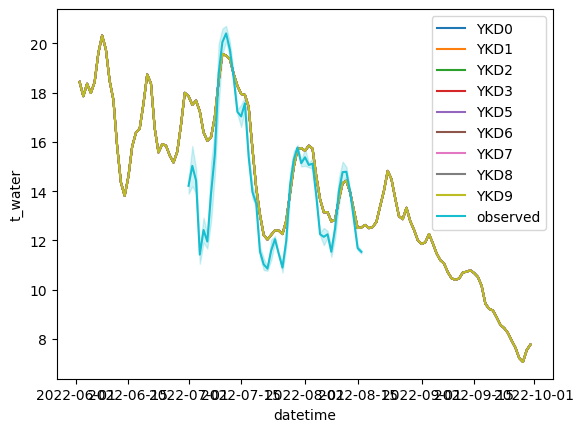

In [16]:
sns.lineplot(data= burned_vars_df[(burned_vars_df['t_water']!=-999)& (burned_vars_df['depth']==-1)], x='datetime', y='t_water', hue = 'run_name')
sns.lineplot(data=burned_co2_obs, x='Date', y='WaterTemp_degC', label='observed')

In [20]:
burned_water_comp = burned_vars_df.loc[(burned_vars_df['t_water']!=-999)& (burned_vars_df['depth']==-1), ['t_water', 'datetime']]

burned_water_comp = burned_water_comp.merge(burned_co2_obs, left_on = 'datetime', right_on='Date')
burned_water_comp = burned_water_comp[(~burned_water_comp['WaterTemp_degC'].isna()) & (~burned_water_comp['t_water'].isna())]


In [24]:
r2_score(burned_water_comp['WaterTemp_degC'], burned_water_comp['t_water'])

0.42703696382874845

In [31]:
mean_absolute_error(burned_water_comp['WaterTemp_degC'], burned_water_comp['t_water'])

1.624711704688495

In [27]:
unburned_co2_obs['Date.1'] = pd.to_datetime(unburned_co2_obs['Date.1'])

In [28]:
unburned_water_comp = unburned_vars_df.loc[(unburned_vars_df['t_water']!=-999)& (unburned_vars_df['depth']==-1), ['t_water', 'datetime']]

unburned_water_comp = unburned_water_comp.merge(unburned_co2_obs, left_on = 'datetime', right_on='Date.1')
unburned_water_comp = unburned_water_comp[(~unburned_water_comp['WaterTemp_degC'].isna()) & (~unburned_water_comp['t_water'].isna())]

In [29]:
r2_score(unburned_water_comp['WaterTemp_degC'], unburned_water_comp['t_water'])

0.8435224936931769

In [32]:
mean_absolute_error(unburned_water_comp['WaterTemp_degC'], unburned_water_comp['t_water'])

1.0222295446792458

In [33]:
(1.02+1.63)/2

1.325

(0.0, 5000.0)

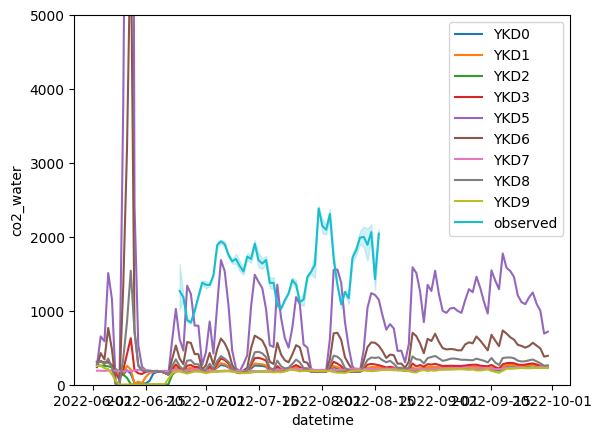

In [34]:
sns.lineplot(data= burned_vars_df[(burned_vars_df['co2_water']!=-999 ) & (burned_vars_df['depth']==-1)], x='datetime', y='co2_water', hue = 'run_name')
sns.lineplot(data= burned_co2_obs, x='Date', y='CO2_High_ppm', label='observed')
plt.ylim(0,5000)

In [35]:
np.nanmean(burned_co2_obs['CO2_High_ppm'])

1544.8153611969876

<Axes: xlabel='datetime', ylabel='doc_water'>

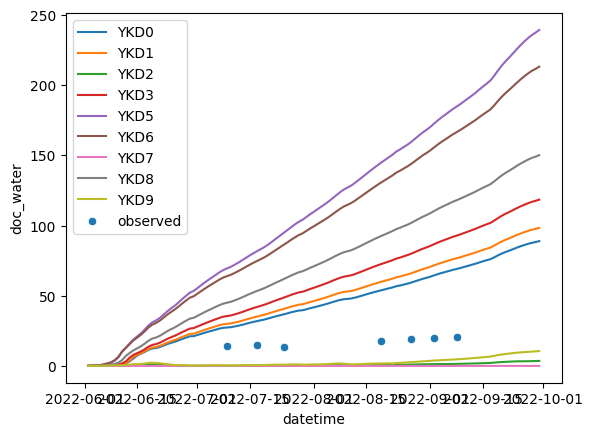

In [36]:
sns.lineplot(data= burned_vars_df[(burned_vars_df['doc_water']!=-999) & (burned_vars_df['depth']==-1)], x='datetime', y='doc_water', hue = 'run_name')
sns.scatterplot(data=ch4_obs[ch4_obs['sample']=='15B_FP'], x='date', y='TOC (mg/L)', label='observed')

In [37]:
ch4_obs.columns

Index(['sample', 'date', 'coords_west', 'coords_east', 'system_type',
       'burn_history', 'burn_year', 'CH4_ppm', 'CO2_ppm', 'CN_filt_vol',
       'temp_C', 'pressure_atm', 'DO_mg_L', 'cond_uS_cm', 'pH', 'ORP',
       'TOC (mg/L)', 'TN (mg/L)', 'd18O (VSMOW)', 'dD (VSMOW)', 'a250', 'A254',
       'a350', 'a375', 'S_275_295', 'S_R', 'SUVA'],
      dtype='object')

(0.0, 100.0)

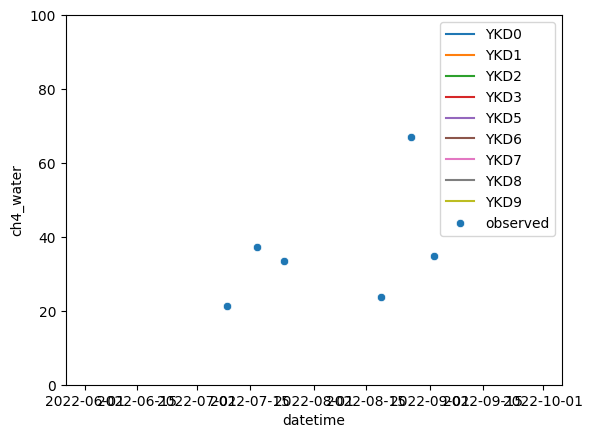

In [38]:
sns.lineplot(data= burned_vars_df[(burned_vars_df['ch4_water']!=-999)  & (burned_vars_df['depth']==-1)], x='datetime', y='ch4_water', hue = 'run_name')
sns.scatterplot(data=ch4_obs[ch4_obs['sample']=='15B_FP'], x='date', y='CH4_ppm', label='observed')
plt.ylim(0,100)

In [46]:
np.median(ch4_obs.loc[ch4_obs['sample']=='15B_FP', 'CH4_ppm'])

34.71996331

<Axes: xlabel='date', ylabel='pH'>

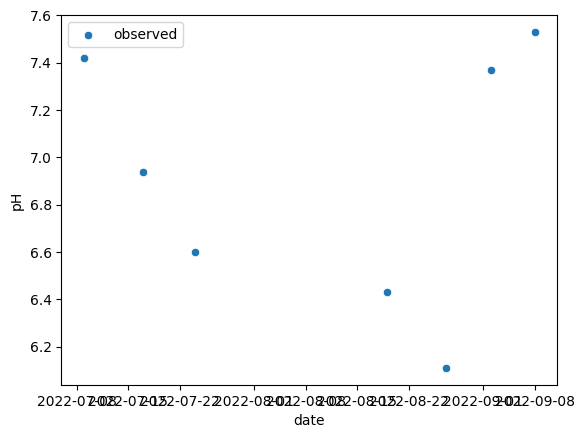

In [39]:
sns.scatterplot(data=ch4_obs[ch4_obs['sample']=='15B_FP'], x='date', y='pH', label='observed')

<Axes: xlabel='datetime', ylabel='o2_water'>

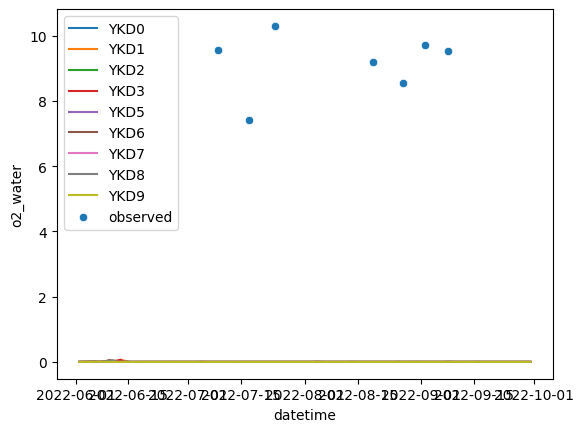

In [40]:
sns.lineplot(data= burned_vars_df[(burned_vars_df['o2_water']!=-999)  & (burned_vars_df['depth']==-1)], x='datetime', y='o2_water', hue = 'run_name')
sns.scatterplot(data=ch4_obs[ch4_obs['sample']=='15B_FP'], x='date', y='DO_mg_L', label='observed')

### Unburned Plots

<Axes: xlabel='datetime', ylabel='t_water'>

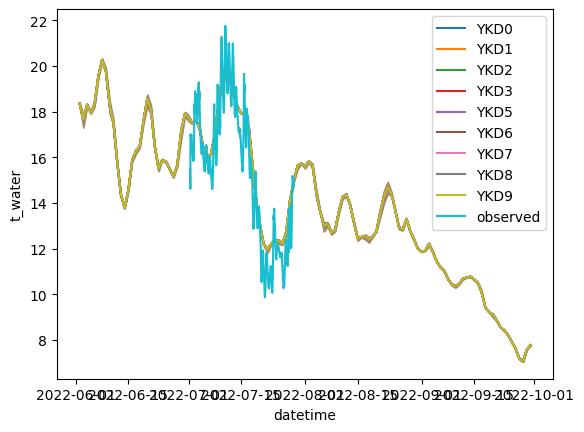

In [41]:
sns.lineplot(data= unburned_vars_df[unburned_vars_df['t_water']!=-999], x='datetime', y='t_water', hue = 'run_name')
sns.lineplot(data=unburned_co2_obs, x='Date', y='WaterTemp_degC', label='observed')

(0.0, 8000.0)

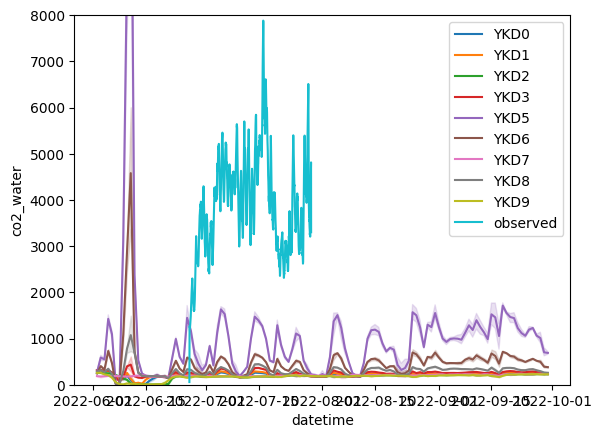

In [42]:
sns.lineplot(data= unburned_vars_df[unburned_vars_df['co2_water']!=-999], x='datetime', y='co2_water', hue = 'run_name')
sns.lineplot(data=unburned_co2_obs, x='Date', y='CO2_High_ppm', label='observed')
plt.ylim(0,8000)

In [48]:
np.nanmean(unburned_co2_obs['CO2_High_ppm'])

3909.0094020437023

(0.0, 100.0)

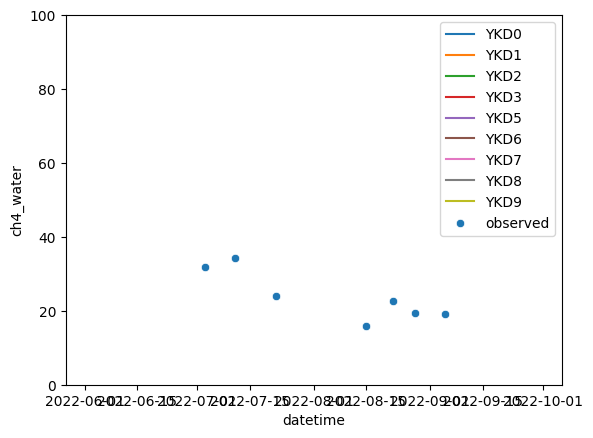

In [43]:
sns.lineplot(data= unburned_vars_df[unburned_vars_df['ch4_water']!=-999], x='datetime', y='ch4_water', hue = 'run_name')
sns.scatterplot(data=ch4_obs[ch4_obs['sample']=='UB_FP'], x='date', y='CH4_ppm', label='observed')
plt.ylim(0,100)

In [49]:
np.nanmean(ch4_obs.loc[ch4_obs['sample']=='UB_FP', 'CH4_ppm'])

23.91572493285715

<Axes: xlabel='date', ylabel='pH'>

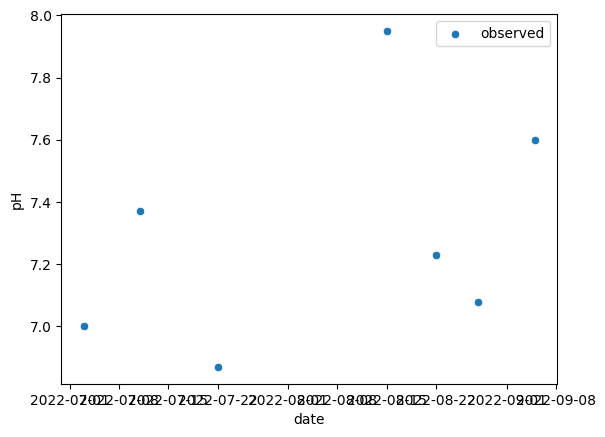

In [44]:
sns.scatterplot(data=ch4_obs[ch4_obs['sample']=='UB_FP'], x='date', y='pH', label='observed')